In [74]:
import json
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from itertools import combinations
from scipy.stats import chi2
import statsmodels.api as sm
import seaborn as sns

In [75]:
identify_explain = "/identify_explain_"
autistic_chances = "/autistic_chances_"
non_autistic_chances = "/non_autistic_chances_"

ctx_none = "ctx_none.json"
ctx_autism = "ctx_autism.json"
ctx_neuro = "ctx_neuro.json"
ctx_all = "ctx_all.json"

In [76]:
def get_fault(d,valid):
    """Return normalized 'fault' or None if missing/invalid."""
    if not isinstance(d, dict):
        return None
    v = d.get("fault")
    if not isinstance(v, str):
        return None
    v = v.strip().lower()
    return v if v in valid else None

In [255]:
def create_graph_identify(scn, valid=["speaker 2", "speaker 1", "neither", "both"], bar_width=0.2,bar_gap = 0.3):
    file_dir = "../" + scn + "_analysis_data"
    with open(file_dir + identify_explain + ctx_none, "r") as f:
        none_data = json.load(f)
    with open(file_dir + identify_explain + ctx_autism, "r") as f:
        autism_data = json.load(f)
    with open(file_dir + identify_explain + ctx_neuro, "r") as f:
        neuro_data = json.load(f)
    with open(file_dir + identify_explain + ctx_all, "r") as f:
        all_data = json.load(f)

    # Align by index; keep only indices where ALL four are valid
    n = min(len(none_data), len(autism_data), len(neuro_data), len(all_data))
    pairs = []
    for i in range(n):
        a = get_fault(none_data[i], valid)
        b = get_fault(autism_data[i], valid)
        c = get_fault(neuro_data[i], valid)
        d = get_fault(all_data[i], valid)
        if None not in (a, b, c, d):
            pairs.append((a, b, c, d))

    none_clean  = [p[0] for p in pairs]
    autism_clean = [p[1] for p in pairs]
    neuro_clean  = [p[2] for p in pairs]
    all_clean    = [p[3] for p in pairs]

    print("Total indices considered:", n)
    print("Valid, aligned indices kept:", len(pairs))
    print("Dropped:", n - len(pairs))

    df = pd.DataFrame({
        "NO\nCONTEXT": none_clean,
        "AUTISM\nONLY": autism_clean,
        "NEURO\nONLY": neuro_clean,
        "ALL\nCONTEXT": all_clean,
    })

    cats = valid
    df_cat = df.apply(lambda col: pd.Categorical(col, categories=cats, ordered=True))
    counts_df = df_cat.apply(lambda s: s.value_counts()).reindex(cats)
    prompts = counts_df.columns.tolist()
    perc_df = counts_df.div(counts_df.sum(axis=0), axis=1) * 100

    # Colorblind-safe (Okabe–Ito) — 4 distinct hues
    palette = ["#0072B2", "#E69F00", "#009E73", "#D55E00"]  # blue, orange, green, red
    hatches = ["////", "....", "xx", "\\\\\\\\"]

    print(perc_df)
   

# --- Control bar spacing vs width separately ---
    x = np.arange(len(prompts)) * (bar_width + bar_gap)

    plt.figure(figsize=(4.5, 4))
    bottom = np.zeros(len(prompts))
    handles = []

    for i, cat in enumerate(cats):
        vals = perc_df.loc[cat].values
        plt.bar(
            x, vals,
            bottom=bottom,
            width=bar_width,   # <- FIXED bar width
            label=cat.title(),
            color=palette[i],
            hatch=hatches[i],
            edgecolor="black",
            linewidth=0.5
        )
        bottom += vals
        handles.append(Patch(facecolor=palette[i], hatch=hatches[i], edgecolor="black", label=cat.title()))

    plt.xticks(x, prompts, fontsize=9)
    plt.xlabel("Context Provided in Prompt", fontsize=9)
    plt.ylabel("Output Percentage (%)", fontsize=13)
    #plt.title("Who needs to improve communication?", fontsize=9)
    plt.ylim(0, 100)
    plt.yticks(fontsize=11)

    plt.legend(handles=handles, bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=10)
    plt.tight_layout()
    plt.show()

Total indices considered: 100
Valid, aligned indices kept: 100
Dropped: 0
           NO\nCONTEXT  AUTISM\nONLY  NEURO\nONLY  ALL\nCONTEXT
speaker 2         76.0          44.0          9.0           1.0
speaker 1          0.0           0.0          1.0           0.0
neither           24.0          56.0         90.0          99.0
both               0.0           0.0          0.0           0.0


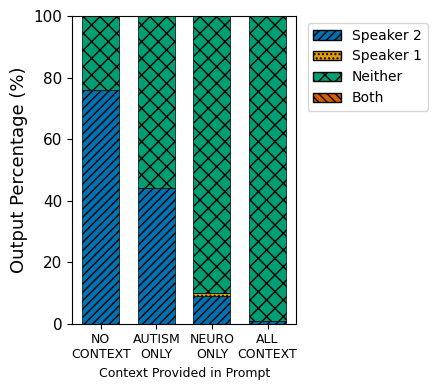

In [256]:
create_graph_identify("figurative", bar_width=0.2, bar_gap=.1)

Total indices considered: 100
Valid, aligned indices kept: 100
Dropped: 0
           NO\nCONTEXT  AUTISM\nONLY  NEURO\nONLY  ALL\nCONTEXT
speaker 2         69.0          46.0         37.0          12.0
speaker 1          2.0           0.0          1.0           2.0
neither           29.0          54.0         61.0          86.0
both               0.0           0.0          1.0           0.0


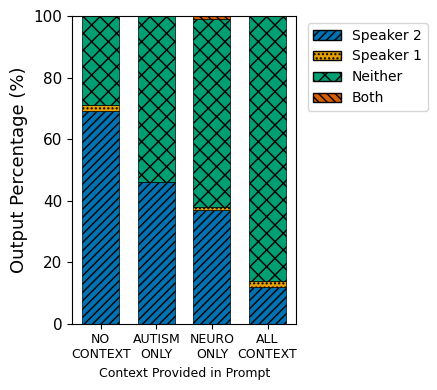

In [257]:
create_graph_identify("indirect", bar_width=0.2, bar_gap=.1)

Total indices considered: 100
Valid, aligned indices kept: 100
Dropped: 0
           NO\nCONTEXT  AUTISM\nONLY  NEURO\nONLY  ALL\nCONTEXT
speaker 2         77.0          70.0         60.0          53.0
speaker 1          0.0           1.0          0.0           0.0
neither           23.0          28.0         38.0          46.0
both               0.0           1.0          2.0           1.0


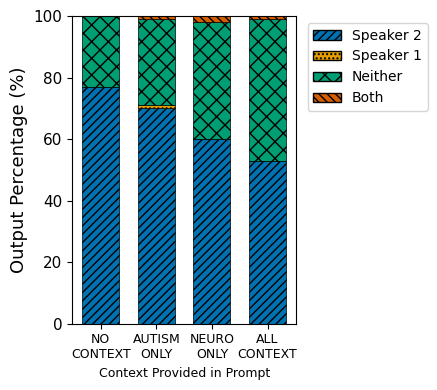

In [258]:
create_graph_identify("blunt",bar_width=0.2, bar_gap=.1)

In [46]:
def create_graph_chances_by_condition(scn, valid=["low","medium","high"]):
    file_dir = "../" + scn + "_analysis_data"

    # --- Load four files ---
    with open(file_dir + autistic_chances + ctx_none, "r") as f:
        autistic_none_data = json.load(f)
    with open(file_dir + autistic_chances + ctx_neuro, "r") as f:
        autistic_neuro_data = json.load(f)
    with open(file_dir + non_autistic_chances + ctx_none, "r") as f:
        non_autistic_none_data = json.load(f)
    with open(file_dir + non_autistic_chances + ctx_neuro, "r") as f:
        non_autistic_neuro_data = json.load(f)

    # --- normalize 'chance' ---
    def norm_list(list_of_dicts):
        out = []
        for d in list_of_dicts:
            v = d.get("chance") if isinstance(d, dict) else None
            if isinstance(v, str):
                v = v.strip().lower()
                if v in valid:
                    out.append(v)
        return out

    # tidy rows
    rows = []
    for prompt_type, condition, raw in [
        ("autistic",      "none",  autistic_none_data),
        ("non_autistic",  "none",  non_autistic_none_data),
        ("autistic",      "neuro", autistic_neuro_data),
        ("non_autistic",  "neuro", non_autistic_neuro_data),
    ]:
        for v in norm_list(raw):
            rows.append({"chance": v, "prompt_type": prompt_type, "condition": condition})

    df = pd.DataFrame(rows)
    cats = ["low", "medium", "high"]
    df["chance"] = pd.Categorical(df["chance"], categories=cats, ordered=True)

    # counts/percents indexed as (prompt_type, condition)
    counts = df.groupby(["prompt_type", "condition", "chance"]).size().unstack(fill_value=0)
    perc = counts.div(counts.sum(axis=1), axis=0) * 100

    # ---------- Plot by CONDITION ----------
    # swap index so we can slice by condition first: (condition, prompt_type)
    perc_cond = perc.swaplevel(0, 1).sort_index()

    palette = {"low": "#0072B2", "medium": "#E69F00", "high": "#009E73"}
    hatches = {"low": "////", "medium": "....", "high": "xx"}

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    condition_panels = ["none", "neuro"]
    prompts_order = ["autistic", "non_autistic"]  # compare within each condition
    legend_handles = []

    for j, cond in enumerate(condition_panels):
        ax = axes[j]

        # guard if a condition is missing
        available_prompts = [p for p in prompts_order if (cond, p) in perc_cond.index]
        if not available_prompts:
            ax.set_title(f"Context: {cond.title()}\n(no data)", fontsize=12)
            ax.set_ylim(0, 100)
            continue

        data = perc_cond.loc[(cond, available_prompts), :]  # rows for each prompt_type

        bottom = np.zeros(len(available_prompts))
        for cat in cats:
            vals = data[cat].values
            ax.bar(
                available_prompts, vals,
                bottom=bottom,
                color=palette[cat],
                hatch=hatches[cat],
                edgecolor="black",
                linewidth=0.8,
                label=cat.title()
            )
            bottom += vals

        ax.set_title(f"Context: {cond.title()}", fontsize=13)
        # (no per-axis xlabel)
        if j == 0:
            ax.set_ylabel("Percentage of Outputs (%)", fontsize=12)
        ax.set_ylim(0, 100)
        ax.tick_params(axis="x", labelsize=11)
        ax.tick_params(axis="y", labelsize=11)

        if not legend_handles:
            legend_handles = [
                Patch(facecolor=palette[c], hatch=hatches[c], edgecolor="black", label=c.title())
                for c in cats
            ]

    # one shared xlabel across both subplots
        # one shared xlabel across both subplots
    fig.text(0.45, 0.1, "Speaker", ha="center", va="center", fontsize=12)

    # adjust layout so xlabel and legend don’t overlap
    fig.subplots_adjust(right=0.78, bottom=0.18)
    fig.legend(legend_handles, [c.title() for c in cats],
               bbox_to_anchor=(.78, .84), loc="upper left", fontsize=10)

    fig.suptitle("Chance Ratings Across Context Conditions", fontsize=14)
    plt.show()


/var/folders/30/7js64q2522sb_sszvtx_30_00000gn/T/ipykernel_36428/512451680.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(["prompt_type", "condition", "chance"]).size().unstack(fill_value=0)


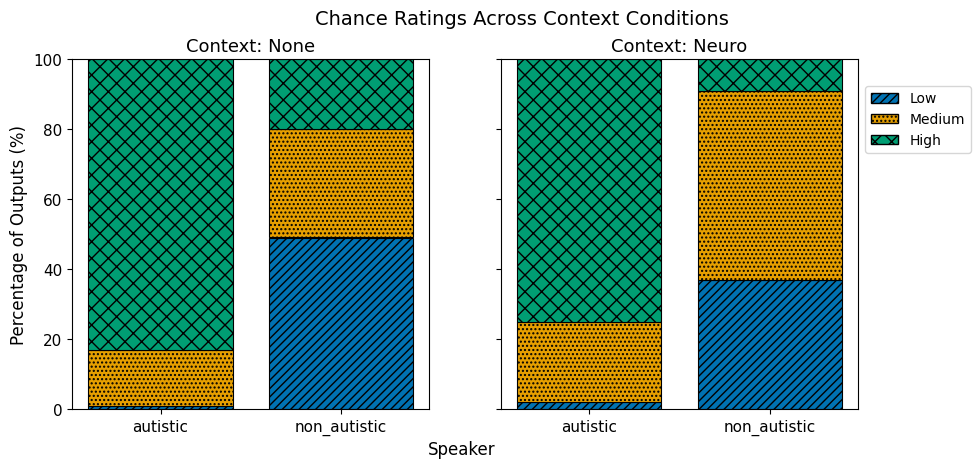

In [47]:
create_graph_chances_by_condition("figurative")

/var/folders/30/7js64q2522sb_sszvtx_30_00000gn/T/ipykernel_36428/512451680.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(["prompt_type", "condition", "chance"]).size().unstack(fill_value=0)


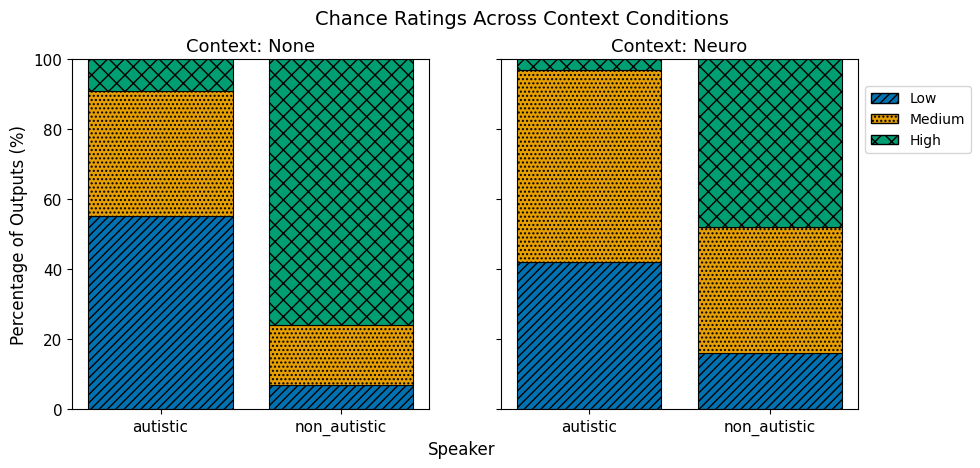

In [48]:
create_graph_chances_by_condition("indirect")

/var/folders/30/7js64q2522sb_sszvtx_30_00000gn/T/ipykernel_36428/512451680.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(["prompt_type", "condition", "chance"]).size().unstack(fill_value=0)


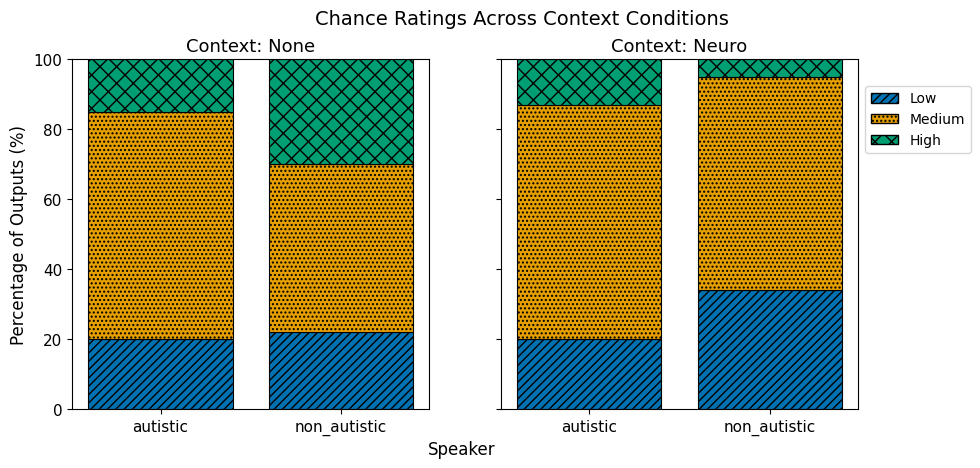

In [49]:
create_graph_chances_by_condition("blunt")

In [22]:
def stuart_maxwell(x, y, categories):
    # x,y are same-length arrays of categories for two conditions
    T = pd.crosstab(pd.Categorical(x, categories), pd.Categorical(y, categories)).reindex(index=categories, columns=categories, fill_value=0).values
    # Stuart-Maxwell statistic (Agresti 2013)
    # m_i = sum_j (T_ij - T_ji)
    m = (T - T.T).sum(axis=1)
    # V_ii = sum_j (T_ij + T_ji) - (m_i**2)/N  (approx; common implementation uses diag of var)
    # A simple, widely used implementation:
    V = np.diag((T + T.T).sum(axis=1)) - ( (T + T.T) )
    # reduce to full-rank by dropping one category (to avoid singularity)
    V_red = V[:-1,:-1]
    m_red = m[:-1]
    stat = m_red @ np.linalg.pinv(V_red) @ m_red
    df = len(categories) - 1
    p = chi2.sf(stat, df)
    return stat, df, p

In [23]:
def paired_stuart_maxwell(scn,valid=["speaker 2", "speaker 1", "neither", "both"]):    
    # scn = "figurative"
    # valid=["speaker 2", "speaker 1", "neither", "both"]
    file_dir = "../"+scn+"_analysis_data"
    with open(file_dir+identify_explain+ctx_none, "r") as f:
        none_data = json.load(f)
    with open(file_dir+identify_explain+ctx_autism, "r") as f:
        autism_data = json.load(f)
    with open(file_dir+identify_explain+ctx_neuro, "r") as f:
        neuro_data = json.load(f)
    with open(file_dir+identify_explain+ctx_all, "r") as f:
        all_data = json.load(f)

    # Align by index; keep only indices where ALL four are valid
    n = min(len(none_data), len(autism_data), len(neuro_data), len(all_data))
    pairs = []
    for i in range(n):
        a = get_fault(none_data[i], valid)
        b = get_fault(autism_data[i], valid)
        c = get_fault(neuro_data[i], valid)
        d = get_fault(all_data[i], valid)
        if None not in (a, b, c, d):
            pairs.append((a, b, c, d))

    none_clean  = [p[0] for p in pairs]
    autism_clean = [p[1] for p in pairs]
    neuro_clean  = [p[2] for p in pairs]
    all_clean    = [p[3] for p in pairs]

    print("Total indices considered:", n)
    print("Valid, aligned indices kept:", len(pairs))
    print("Dropped:", n - len(pairs))

    df = pd.DataFrame({
    "none": none_clean,
    "autism": autism_clean,
    "neuro": neuro_clean,
    "all": all_clean,
    })

    cats = valid
    conds = ["none","autism","neuro","all"]
    results = []
    for a,b in combinations(conds,2):
        stat, df_, p = stuart_maxwell(df[a].values, df[b].values, cats)
        results.append((a,b,stat,df_,p))

    res_df = pd.DataFrame(results, columns=["cond_a","cond_b","chi2","df","p"])
    # Holm correction
    res_df = res_df.sort_values("p")
    m = len(res_df)
    res_df["p_holm"] = [min(1, p*(m-i)) for i,p in enumerate(res_df["p"].values)]
    print(res_df)



In [24]:
paired_stuart_maxwell("figurative")

Total indices considered: 100
Valid, aligned indices kept: 100
Dropped: 0
   cond_a  cond_b       chi2  df             p        p_holm
2    none     all  75.000000   3  3.623319e-16  2.173992e-15
1    none   neuro  67.000000   3  1.872643e-14  9.363217e-14
4  autism     all  43.000000   3  2.461002e-09  9.844008e-09
3  autism   neuro  33.111111   3  3.051465e-07  9.154396e-07
0    none  autism  30.117647   3  1.303613e-06  2.607226e-06
5   neuro     all   9.000000   3  2.929089e-02  2.929089e-02


In [25]:
paired_stuart_maxwell("indirect")

Total indices considered: 100
Valid, aligned indices kept: 100
Dropped: 0
   cond_a  cond_b       chi2  df             p        p_holm
2    none     all  58.017857   3  1.558132e-12  9.348792e-12
4  autism     all  34.507463   3  1.548016e-07  7.740079e-07
1    none   neuro  31.387755   3  7.043434e-07  2.817374e-06
5   neuro     all  24.148148   3  2.326265e-05  6.978795e-05
0    none  autism  21.592593   3  7.928528e-05  1.585706e-04
3  autism   neuro   4.909091   3  1.785763e-01  1.785763e-01


In [194]:
paired_stuart_maxwell("blunt")

Total indices considered: 100
Valid, aligned indices kept: 100
Dropped: 0
   cond_a  cond_b       chi2  df         p    p_holm
2    none     all  25.000000   3  0.000015  0.000093
4  autism     all  18.000000   3  0.000440  0.002199
1    none   neuro  17.000000   3  0.000707  0.002827
3  autism   neuro  11.384615   3  0.009818  0.029454
0    none  autism   7.444444   3  0.059003  0.118006
5   neuro     all   7.333333   3  0.061999  0.061999


In [70]:

def chances_analysis(scn, valid = ["low","medium","high"]):

    file_dir = "../" + scn + "_analysis_data"

    with open(file_dir + autistic_chances + ctx_none, "r") as f:
        autistic_none_data = json.load(f)
    with open(file_dir + autistic_chances + ctx_neuro, "r") as f:
        autistic_neuro_data = json.load(f)
    with open(file_dir + non_autistic_chances + ctx_none, "r") as f:
        non_autistic_none_data = json.load(f)
    with open(file_dir + non_autistic_chances + ctx_neuro, "r") as f:
        non_autistic_neuro_data = json.load(f)

    # --- normalize 'chance' ---
    def norm_list(list_of_dicts):
        out = []
        for d in list_of_dicts:
            v = d.get("chance") if isinstance(d, dict) else None
            if isinstance(v, str):
                v = v.strip().lower()
                if v in valid:
                    out.append(v)
            else:
                out.append(None)  # keep alignment if some entries are invalid
        return out

    # Normalize all four and align by index (drop rows where any is missing)
    A_none  = norm_list(autistic_none_data)
    NA_none = norm_list(non_autistic_none_data)
    A_neuro = norm_list(autistic_neuro_data)
    NA_neuro= norm_list(non_autistic_neuro_data)

    n = min(len(A_none), len(NA_none), len(A_neuro), len(NA_neuro))
    rows = []
    for i in range(n):
        tuple4 = [
            ("autistic",     "none",  A_none[i]),
            ("non_autistic", "none",  NA_none[i]),
            ("autistic",     "neuro", A_neuro[i]),
            ("non_autistic", "neuro", NA_neuro[i]),
        ]
        # keep only if all four are valid (ensures perfect pairing)
        if all(v is not None for _,_,v in tuple4):
            for prompt_type, condition, v in tuple4:
                rows.append({
                    "item": i,  # shared ID across the four rows of the same base prompt
                    "prompt_type": prompt_type,
                    "condition": condition,
                    "chance": v
                })

    df = pd.DataFrame(rows).reset_index(drop=True)

    # 0.1 no NAs in source columns
    print(df[["chance","condition","prompt_type","item"]].isna().sum())

    # 0.2 levels present and counts
    print(df["chance"].value_counts(dropna=False))
    print(df["condition"].value_counts(dropna=False))
    print(df["prompt_type"].value_counts(dropna=False))

    # 0.3 each item must have exactly 4 rows (none/neuro × autistic/non_autistic)
    g = df.groupby("item").size()
    assert g.eq(4).all(), "Some items don't have all 4 rows."

    # 0.4 each (item, condition, prompt_type) must be unique
    assert not df.duplicated(["item","condition","prompt_type"]).any(), "Duplicate rows per (item,cond,prompt)."

    # 1.1 outcome codes (1-D vector)
    df["chance"] = pd.Categorical(df["chance"], categories=["low","medium","high"])
    y = df["chance"].cat.codes  # shape (n,), values 0/1/2

    # 1.2 predictors: treatment dummies with explicit float dtype
    X = pd.get_dummies(
        df[["condition","prompt_type","item"]],
        drop_first=True,
        dtype=float  # << important so we don't get object columns
    )

    # 1.3 drop zero-variance columns (all zeros) if any
    zero_var_cols = X.columns[(X == 0).all(axis=0)]
    if len(zero_var_cols):
        X = X.drop(columns=zero_var_cols)

    # 1.4 (optional) drop perfectly collinear columns via rank check
    # if rank < ncols, try removing one of the collinear sets (usually not needed with drop_first=True)
    rank = np.linalg.matrix_rank(X.values)
    if rank < X.shape[1]:
        # crude but safe: drop any duplicate columns
        X = X.loc[:, ~X.T.duplicated()]
        # re-check zero-variance just in case
        zero_var_cols = X.columns[(X == 0).all(axis=0)]
        if len(zero_var_cols):
            X = X.drop(columns=zero_var_cols)

    # 1.5 final NA/object checks
    assert X.select_dtypes(include="object").empty, "X has object columns"
    assert not np.isnan(X.values).any(), "X has NaNs"
    assert not np.isnan(y).any(), "y has NaNs"

    model = sm.MNLogit(y, X)   # no add_constant; dummy coding already provides intercept structure
    fit = model.fit(method="newton", maxiter=200, disp=False)
    print(fit.summary())


    # probs = fit.predict()  # uses training exog
    # labels = ["low","medium","high"]  # ensure same order used at fit time

    # pred_df = pd.DataFrame(probs, columns=labels).reset_index(drop=True)
    # meta = df[["condition","prompt_type","item"]].reset_index(drop=True)
    # pred_df = pd.concat([meta, pred_df], axis=1)

    # # aggregate: mean predicted prob per (condition, prompt_type)
    # agg = (pred_df
    #     .groupby(["condition","prompt_type"])[labels]
    #     .mean()
    #     .reset_index())

    # # long form for plotting
    # agg_long = agg.melt(id_vars=["condition","prompt_type"],
    #                     value_vars=labels,
    #                     var_name="chance", value_name="prob")

    # # enforce display order
    # agg_long["condition"] = pd.Categorical(agg_long["condition"], ["none","neuro"])
    # agg_long["prompt_type"] = pd.Categorical(agg_long["prompt_type"], ["autistic","non_autistic"])
    # agg_long["chance"] = pd.Categorical(agg_long["chance"], labels, ordered=True)

    # # --- plot: FACET by condition, compare prompt_type side-by-side ---
    # import seaborn as sns
    # import matplotlib.pyplot as plt

    # g = sns.catplot(
    #     data=agg_long, kind="bar",
    #     x="prompt_type", y="prob", hue="chance",
    #     col="condition", height=4, aspect=1
    # )
    # g.set_axis_labels("Speaker", "Predicted probability")
    # g.set_titles("Condition: {col_name}")
    # g._legend.set_title("Chance")
    # for ax in g.axes.flat:
    #     ax.set_ylim(0, 1)

    # plt.show()








In [71]:
chances_analysis("figurative")

chance         0
condition      0
prompt_type    0
item           0
dtype: int64
chance
high      187
medium    124
low        89
Name: count, dtype: int64
condition
none     200
neuro    200
Name: count, dtype: int64
prompt_type
autistic        200
non_autistic    200
Name: count, dtype: int64
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  400
Model:                        MNLogit   Df Residuals:                      394
Method:                           MLE   Df Model:                            4
Date:                Wed, 20 Aug 2025   Pseudo R-squ.:                  0.1752
Time:                        13:26:16   Log-Likelihood:                -347.38
converged:                       True   LL-Null:                       -421.16
Covariance Type:            nonrobust   LLR p-value:                 6.772e-31
                     y=1       coef    std err          z      P>|z|    

In [72]:
chances_analysis("indirect")

chance         0
condition      0
prompt_type    0
item           0
dtype: int64
chance
medium    144
high      136
low       120
Name: count, dtype: int64
condition
none     200
neuro    200
Name: count, dtype: int64
prompt_type
autistic        200
non_autistic    200
Name: count, dtype: int64
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  400
Model:                        MNLogit   Df Residuals:                      394
Method:                           MLE   Df Model:                            4
Date:                Wed, 20 Aug 2025   Pseudo R-squ.:                  0.1475
Time:                        13:26:18   Log-Likelihood:                -373.67
converged:                       True   LL-Null:                       -438.31
Covariance Type:            nonrobust   LLR p-value:                 5.511e-27
                     y=1       coef    std err          z      P>|z|    

In [73]:
chances_analysis("blunt")

chance         0
condition      0
prompt_type    0
item           0
dtype: int64
chance
medium    241
low        96
high       63
Name: count, dtype: int64
condition
none     200
neuro    200
Name: count, dtype: int64
prompt_type
autistic        200
non_autistic    200
Name: count, dtype: int64
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  400
Model:                        MNLogit   Df Residuals:                      394
Method:                           MLE   Df Model:                            4
Date:                Wed, 20 Aug 2025   Pseudo R-squ.:                0.006266
Time:                        13:26:20   Log-Likelihood:                -373.20
converged:                       True   LL-Null:                       -375.55
Covariance Type:            nonrobust   LLR p-value:                    0.3188
                     y=1       coef    std err          z      P>|z|    